In [10]:
import bk.load
import bk.signal
import bk.plot
import bk.compute

import neuroseries as nts
import matplotlib.pyplot as plt


import scipy.signal
from scipy.stats import zscore
import numpy as np
import seaborn as sns
import pandas as pd

from tqdm import tqdm

plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('ggplot')

In [7]:
# Deprecated

def write_bla_theta_bouts(base_folder, local_path, *args, **kwargs):
    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    bla_channels = bk.load.bla_channels()
    bla_channel = [c[1] for c in bla_channels.items() if ~np.isnan(c[1])][0]
    print(bla_channel)
    states = bk.load.states()

    lfp = bk.load.lfp_in_intervals(bla_channel,states['Rem'])
    theta_bouts = bk.signal.power_bouts(lfp, 6, 10, 1.5)
    theta_bouts = theta_bouts.merge_close_intervals(0.1,'s')
    theta_bouts = theta_bouts.drop_short_intervals(0.2, 's')
    theta_bouts = theta_bouts.iloc[theta_bouts.duration('s')<10]

    theta_bouts['state'] = 'THETA'
    # theta_bouts.to_csv('Intervals/BLA_REM_theta_bouts.csv',index = False)

    return theta_bouts

In [2]:
def triggered_average(signal,timestamps,win_size,fs = 1250):
    n_samples = int(np.ceil(1250*win_size/2))
    averaged = np.zeros((len(timestamps),n_samples*2))
    for i,t in tqdm(enumerate(timestamps.values),total = len(timestamps)):
        peak_i = np.where(signal.index.values == t)[0][0]
        trig = signal.iloc[peak_i-n_samples:peak_i+n_samples]
        if len(trig) == n_samples*2: averaged[i,:] = trig
    averaged = averaged[np.sum(averaged,1) !=0]
    
    t = np.linspace(-n_samples/1250,n_samples/1250,n_samples*2)
    return t,averaged

In [8]:
## Same as above but saving left and right theta bouts separ
def write_bla_theta_bouts(base_folder, local_path, *args, **kwargs):
    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    bla_channels = bk.load.bla_channels()
    states = bk.load.states()
    to_write = pd.DataFrame()

    for side in ['left','right']:
        if np.isnan(bla_channels[side]):
            continue
        lfp = bk.load.lfp_in_intervals(bla_channels[side],states['Rem'])
        lfp_filt = bk.signal.passband(lfp,6,10)
        theta_bouts = bk.signal.power_bouts(lfp, 6, 10, 1.5)
        theta_bouts = theta_bouts.merge_close_intervals(0.1,'s')
        theta_bouts = theta_bouts.drop_short_intervals(0.2, 's')
        theta_bouts = theta_bouts.iloc[theta_bouts.duration('s')<10]
        
        theta_peaks = []
        for theta in tqdm(theta_bouts.iloc,total = len(theta_bouts)):
            peak = lfp_filt.loc[theta.start:theta.end].index.values[np.argmax(lfp_filt.loc[theta.start:theta.end])]
            theta_peaks.append(peak)

        theta_bouts['peak'] = np.array(theta_peaks)
        theta_bouts['state'] = f'{side}-THETA'
        to_write = pd.concat((to_write,theta_bouts))
    return to_write
    to_write.to_csv('Intervals/BLA_REM_theta_bouts_left_right.csv',index = False)

In [11]:
%matplotlib qt

bk.load.current_session_linux('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130713')
# theta_bouts = bk.load.intervals('BLA_REM_theta_bouts')
theta_bouts = write_bla_theta_bouts('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130713')
theta_bouts = nts.IntervalSet(theta_bouts.start,theta_bouts.end)

states = bk.load.states()
lfp = bk.load.lfp_in_intervals(bk.load.bla_channels()['left'],states['Rem'])
# inter=nts.IntervalSet(5000,7000,'s')



t,f,Sxx = bk.signal.wavelet_spectrogram_intervals(lfp,states['Rem'],fmax = 20)
power =bk.signal.wavelet_bandpower(lfp,6,10)





Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


/tmp/ipykernel_128042/3214303531.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(t,f,Sxx,rasterized = True)


In [12]:
inter = nts.IntervalSet(9399,9402,'s')

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(lfp.restrict(inter).as_units('s'))
plt.sca(ax[0])
bk.plot.intervals(theta_bouts.intersect(inter),'orange')
ax_power = ax[1].twinx()
ax[1].pcolor(t,f,Sxx,rasterized = True)
ax[1].set_ylim(0,20)
ax_power.plot(bk.compute.nts_zscore(power).restrict(inter).as_units('s'),'w')
ax_power.axhline(1.5,color ='red')
plt.show()

/tmp/ipykernel_128042/1643449797.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(t,f,Sxx,rasterized = True)


In [13]:
%matplotlib qt 
bk.load.current_session_linux()
states = bk.load.states()

theta = write_bla_theta_bouts('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130713')
peaks = theta['peak'][theta['state'] == 'left-THETA']
print('Loaded Peaks')

fig,ax = plt.subplots(2,3)
for i,side in enumerate(['left','right','Hpc']):
    print(side)
    if side == 'Hpc':
        lfp = bk.load.lfp_in_intervals(bk.load.ripple_channel(),states['Rem'])
    else:
        lfp = bk.load.lfp_in_intervals(bk.load.bla_channels()[side],states['Rem'])
    
    lfp_filt = bk.signal.passband(lfp,6,10)
    t,averaged = triggered_average(lfp,peaks,2)
    t,averaged_filt = triggered_average(lfp_filt,peaks,2)

    bk.plot.confidence_intervals(t,averaged,'orange',ax[0,i])
    bk.plot.confidence_intervals(t,averaged_filt,'orange',ax[1,i])
    ax[0,i].set_ylim(-50,150)
    ax[1,i].set_ylim(-75,75)
    ax[0,i].set_title(side)



plt.suptitle('Triggered Averaged not filtered')
plt.tight_layout()
plt.show()


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


100%|██████████| 295/295 [00:00<00:00, 529.14it/s]


Loaded Peaks
left


100%|██████████| 289/289 [00:00<00:00, 449.21it/s]


right


100%|██████████| 289/289 [00:00<00:00, 419.39it/s]


Hpc


100%|██████████| 289/289 [00:00<00:00, 454.10it/s]


In [177]:
nts.Ts(np.sort(np.random.choice(lfp_filt.index,1250))).index

Int64Index([ 1928200000,  1929099200,  1931410400,  1932740000,  1936052800,
             1938945600,  1942598400,  1947326400,  1949491200,  1950203200,
            ...
            21927179200, 21929672000, 21931858400, 21934115200, 21934399200,
            21935896000, 21941672000, 21945508000, 21945747200, 21946910400],
           dtype='int64', name='Time (us)', length=1250)

In [178]:
rand = nts.Ts(np.sort(np.random.choice(lfp_filt.index.values,1250))).index
t,averaged = triggered_average(lfp_filt,rand,1)
bk.plot.confidence_intervals(t,averaged,'orange')

100%|██████████| 1250/1250 [00:02<00:00, 425.11it/s]


In [4]:
# bk.load.batch(write_bla_theta_bouts,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/')

In [5]:
# bk.load.current_session_linux()
# neurons, metadata = bk.load.spikes()
# states = bk.load.states()
# theta_bouts = bk.load.intervals('BLA_REM_theta_bouts').drop_short_intervals(0.2,'s').reset_index(drop = True)
# outside_theta_bouts = states['Rem'].set_diff(theta_bouts)

# fr = {'theta_bouts':[],
#     'outside_theta_bouts':[]}
# for n in neurons:
#     fr['theta_bouts'].append(bk.compute.fr(n,theta_bouts))
#     fr['outside_theta_bouts'].append(bk.compute.fr(n,outside_theta_bouts))

# df = pd.DataFrame(fr,columns=['FR_Theta_Bouts','FR_Outside_Theta_Bouts'])
# print(df)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy
Empty DataFrame
Columns: [FR_Theta_Bouts, FR_Outside_Theta_Bouts]
Index: []


In [2]:
def firing_rates_theta_bouts(base_folder, local_path, *args, **kwargs):
    bk.load.current_session_linux(
        base_folder=base_folder, 
        local_path=local_path)
    neurons, metadata = bk.load.spikes()
    thetamod = pd.read_csv('Analysis/Thetamod/hpc_theta_phase_lock.csv')
    states = bk.load.states()
    theta_bouts = bk.load.intervals('BLA_REM_theta_bouts').drop_short_intervals(0.2,'s').reset_index(drop= True)
    outside_theta_bouts = states['Rem'].set_diff(theta_bouts)

    fr = {'theta_bouts':[],
        'outside_theta_bouts':[]}
    for n in neurons:
        fr['theta_bouts'].append(bk.compute.fr(n,theta_bouts))
        fr['outside_theta_bouts'].append(bk.compute.fr(n,outside_theta_bouts))

    df = pd.DataFrame(fr)
    return pd.concat((metadata,df,thetamod.modulated),axis = 1)


In [3]:
batch = bk.load.batch(firing_rates_theta_bouts,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/')

Sessions: 100%|██████████| 61/61 [01:30<00:00,  1.48s/it]

Batch finished in 90.58212447166443
Some session were not processed correctly
['Rat08-20130712', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
54.09836065573771 %


In [10]:
import imp
imp.reload(bk.plot)

<module 'bk.plot' from '/home/billel/pCloudDrive/IFM/work/Code/Python/Billel/bk/plot.py'>

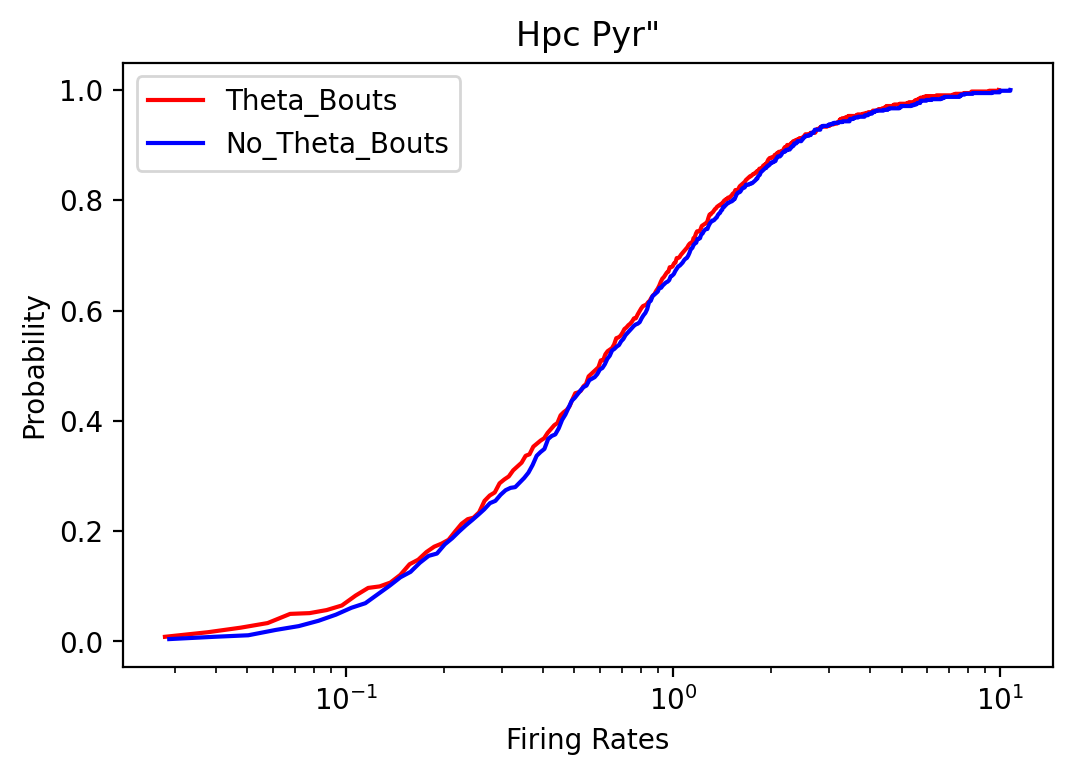

In [30]:
df = pd.concat(batch[0])
df = df[(df['theta_bouts'] != 0) & (df['theta_bouts'] != 0)]
df_fr = df[['theta_bouts','outside_theta_bouts']]
df_fr_mod = df_fr[((df.Region == 'Hpc') & (df.Type == 'Pyr'))]

fig,ax = plt.subplots(1,1,dpi = 200)
bk.plot.cumsum_curves(df_fr_mod['theta_bouts'],1000,'r',ax,log = True)
bk.plot.cumsum_curves(df_fr_mod['outside_theta_bouts'],1000,'b',ax,log = True)

plt.title('Hpc Pyr"')
plt.ylabel('Probability')
plt.xlabel('Firing Rates')

plt.legend(['Theta_Bouts','No_Theta_Bouts'])

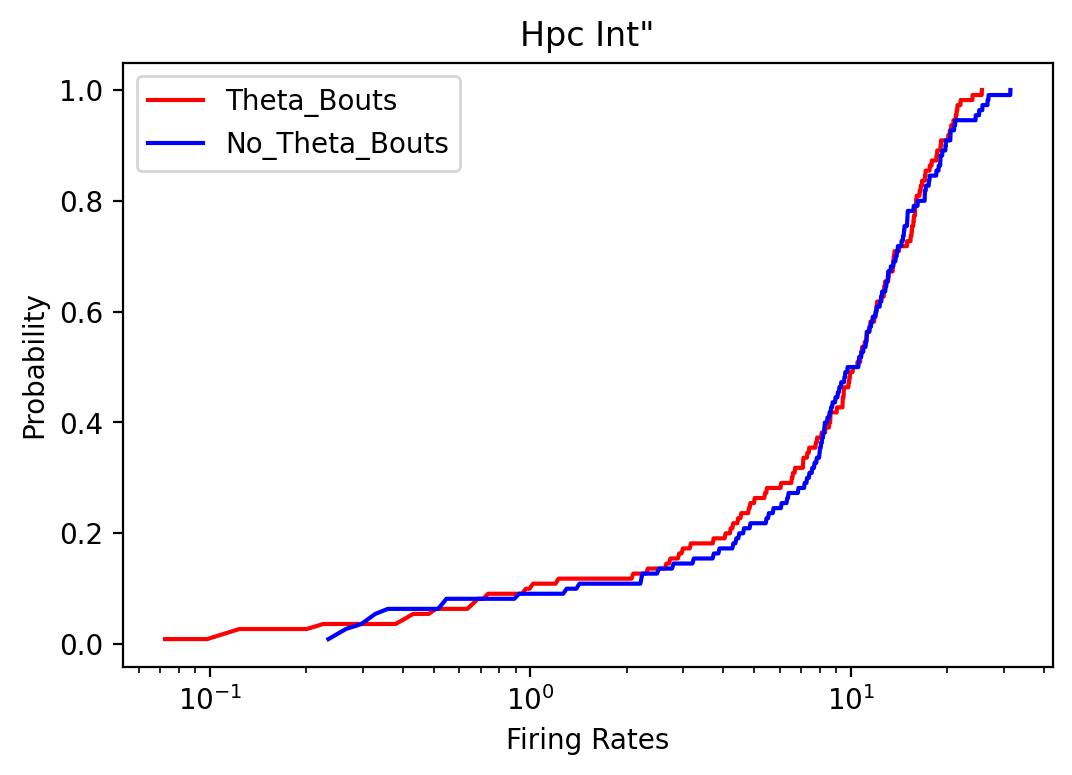

In [27]:
df = pd.concat(batch[0])
df = df[(df['theta_bouts'] != 0) & (df['theta_bouts'] != 0)]
df_fr = df[['theta_bouts','outside_theta_bouts']]
df_fr_mod = df_fr[((df.Region == 'Hpc') & (df.Type == 'Int'))]

fig,ax = plt.subplots(1,1,dpi = 200)
bk.plot.cumsum_curves(df_fr_mod['theta_bouts'],1000,'r',ax,log = True)
bk.plot.cumsum_curves(df_fr_mod['outside_theta_bouts'],1000,'b',ax,log = True)

plt.title('Hpc Int')
plt.ylabel('Probability')
plt.xlabel('Firing Rates')

plt.legend(['Theta_Bouts','No_Theta_Bouts'])

In [31]:
print(np.average(df_fr_mod['theta_bouts']))
print(np.average(df_fr_mod['outside_theta_bouts']))

scipy.stats.wilcoxon(df_fr_mod['theta_bouts'],df_fr_mod['outside_theta_bouts'])

1.0160457451803921
1.074096102108612


WilcoxonResult(statistic=114678.0, pvalue=0.004764835863908178)

8.225288089488252
8.862670709744535


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         1.,  1.,  2.,  2.,  2.,  3.,  1.,  2.,  0.,  3.,  1.,  2.,  0.,
         1.,  2.,  3.,  2.,  3.,  0.,  5.,  3.,  4.,  2.,  5.,  3.,  3.,
         4.,  6.,  5.,  5.,  4.,  6.,  4.,  5.,  5.,  6., 10.,  8.,  5.,
         7., 11.,  8.,  6.,  9., 12., 12.,  9., 13., 15., 12., 16., 14.,
        10., 15., 11., 12., 18., 13., 20., 17., 15., 25., 17., 23., 21.,
        10., 18., 20., 17., 15., 17., 18., 16., 18., 21., 20., 19., 17.,
        22., 20., 19., 16., 17., 24., 17., 13., 13., 13., 22.,  9., 14.,
        12., 16., 12., 17., 10., 12.,  6., 11.,  3.,  7.,  8.,  8., 13.,
         4.,  8.,  5.,  2.,  4.,  4.,  5.,  1.,  4.,  4.,  4.,  5.,  4.,
         3.,  2.,  4.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  2.,  4.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.

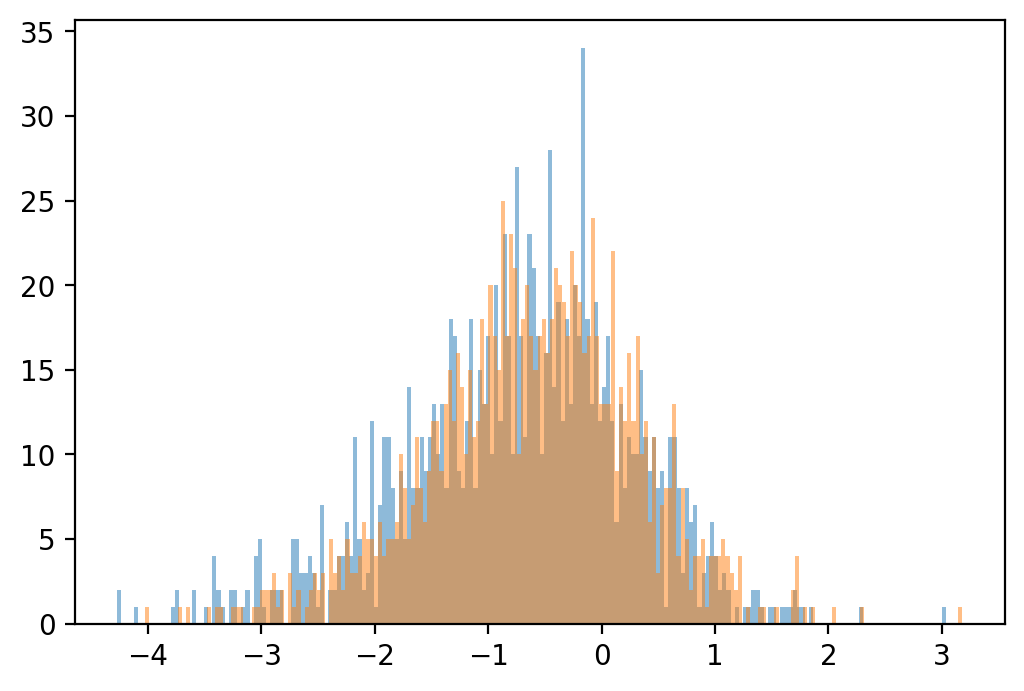

In [14]:
plt.figure(dpi = 200)
plt.hist(np.log(df_fr_mod['theta_bouts']),200,alpha = 0.5)
plt.hist(np.log(df_fr_mod['outside_theta_bouts']),200,alpha = 0.5)


In [86]:
sns.violinplot(data = df_fr[(df.Region == 'BLA') & (df.modulated == True)])

<AxesSubplot:>

In [89]:
scipy.stats.wilcoxon(df_fr_mod['theta_bouts'],df_fr_mod['outside_theta_bouts'])

WilcoxonResult(statistic=5171.0, pvalue=0.0015907016655836155)

In [93]:
np.mean(df_fr_mod['theta_bouts'])

-0.030014068137631914

In [95]:
np.mean(df_fr_mod['outside_theta_bouts'])

0.06420983316107717

In [94]:
def merge_firing_rates_theta_bouts(batch):
    return pd.concat(batch)

In [3]:
def main(base_folder, local_path, *args, **kwargs):
    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    bla_channels = bk.load.bla_channels()
    states = bk.load.states()
    
    lfp = bk.load.lfp_in_intervals(bla_channels['left'],states['Rem'])
    
    t,f,Sxx = bk.signal.wavelet_spectrogram_intervals(lfp,states['Rem'],32,0.5,20,50)

    power = bk.signal.wavelet_bandpower(lfp, 6, 10)
    power_baseline = bk.signal.wavelet_bandpower(lfp, 0.5, 4)
    power = nts.Tsd(power.index.values,power.values/power_baseline.values)
    power = bk.compute.nts_zscore(power)

    theta_bouts = bk.signal.power_bouts(lfp, 6, 10, 1.5, norm=True)
    # theta_bouts = theta_bouts.drop_short_intervals(0.2, 's')
    if len(theta_bouts) == 0:
        return None
    theta_bouts_rates = bk.compute.interval_rates(theta_bouts, 10)
    
    fig, ax = plt.subplots(3, 1, True)
    ax[0].pcolor(t, f, Sxx)
    ax[1].plot(power.as_units('s'))
    # ax[1].plot(theta_bouts_rates.as_units('s'), 'r')
    # ax[1].set_ylim(-4,4)
    plt.sca(ax[1])
    plt.axhline(1.5,color = 'red')
    bk.plot.intervals(theta_bouts, time_units='s')
    ax[2].plot(lfp.as_units('s'))

    plt.suptitle('REM Theta Bouts BLA')

    ax[1].set_ylabel('Power (average wavelet')
    ax[0].set_ylabel('Freq')
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('LFP')


In [5]:
main(base_folder='/mnt/electrophy/Gabrielle/GG-Dataset',local_path='Rat08/Rat08-20130713')
# main(base_folder='/mnt/electrophy/Gabrielle/GG-Dataset',local_path='Rat08/Rat08-20130713')
# main(base_folder='/mnt/electrophy/Gabrielle/GG-Dataset',local_path='Rat08/Rat08-20130714')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset/Rat08/Rat08-20130713


/tmp/ipykernel_150246/2612961313.py:22: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, ax = plt.subplots(3, 1, True)
/tmp/ipykernel_150246/2612961313.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolor(t, f, Sxx)


In [14]:
bk.load.current_session_linux()
neurons, metadata = bk.load.spikes()
bla_channels = bk.load.bla_channels()
states = bk.load.states()

lfp = bk.load.lfp_in_intervals(bla_channels['left'],states['Rem'])

# t,f,Sxx = bk.signal.wavelet_spectrogram_intervals(lfp,states['Rem'],32,0.5,20,50)

# power = bk.signal.wavelet_bandpower(lfp, 6, 10)
# power_baseline = bk.signal.wavelet_bandpower(lfp, 0.5, 4)
# power = nts.Tsd(power.index.values,power.values/power_baseline.values)
# power = bk.compute.nts_zscore(power)

theta_bouts = bk.signal.power_bouts(lfp, 6, 10, 1.5)
theta_bouts = theta_bouts.drop_short_intervals(0.2, 's')
theta_bouts = theta_bouts.iloc[theta_bouts.duration('s')<15]
no_theta_bouts = states['Rem'].set_diff(theta_bouts)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [28]:
f , sxx = scipy.signal.welch(lfp.restrict(theta_bouts).values,1250,nperseg=5000,noverlap=4500)
f,sxx_no = scipy.signal.welch(lfp.restrict(no_theta_bouts).values,1250,nperseg=5000,noverlap=4500)
f,sxx_ctrl = scipy.signal.welch(lfp.restrict(states['Rem']).values,1250,nperseg=5000,noverlap=4500)

In [32]:
plt.plot(f,np.log(sxx))
plt.plot(f,np.log(sxx_no))
plt.plot(f,np.log(sxx_ctrl))

plt.xlim(0,20)
plt.ylim(2.5,7)

plt.legend(['Theta_Bouts','no_theta_bouts','REM_Sleep'])
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('Power Spectrums')


Text(0.5, 1.0, 'Power Spectrums')

In [33]:
fr_theta = []
fr_notheta = []
for n in neurons:
    fr_theta.append(len(n.restrict(theta_bouts))/theta_bouts.tot_length('s'))
    fr_notheta.append(len(n.restrict(no_theta_bouts))/no_theta_bouts.tot_length('s'))

In [29]:
df = pd.DataFrame([fr_notheta,fr_theta]).T

In [33]:
sns.violinplot(data = df[metadata.Region == 'BLA'])

<AxesSubplot:>

In [36]:
df[metadata.Region == 'BLA']

NameError: name 'df' is not defined

In [34]:
bk.plot.intervals(no_theta_bouts)
bk.plot.intervals(theta_bouts,'red')

In [35]:
no_theta_bouts

,start,end
0,1927000000,1930337600
1,1930546400,1948744800
2,1948990400,1949092000
3,1949328800,1950888000
4,1951216800,1952005600
...,...,...
369,21934737600,21935128000
370,21935545600,21937792800
371,21938172000,21938337600
372,21938733600,21950388000


In [35]:
fr = bk.compute.binSpikes(neurons[metadata.Region == 'BLA'],0.025,as_Tsd=True)
z_fr = bk.compute.nts_zscore(fr)

In [49]:
fig,ax = plt.subplots(3,1,True)
plt.sca(ax[0])
bk.plot.intervals(no_theta_bouts)
bk.plot.intervals(theta_bouts,'red')
ax[1].plot(fr.restrict(states['Rem']).as_units('s'))
plt.sca(ax[2])
bk.plot.rasterPlot(neurons[metadata.Region == 'BLA'])

/tmp/ipykernel_154557/4160410391.py:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(3,1,True)


In [39]:
from scipy.stats import zscore

In [43]:
plt.imshow(zscore(fr.values,axis = 0).T,aspect = 'auto')

In [24]:
np.arange(0,len(lfp_theta_bla),1/1250)

array([0.00000000e+00, 8.00000000e-04, 1.60000000e-03, ...,
       1.40023998e+05, 1.40023998e+05, 1.40023999e+05])

In [49]:
np.dim(lfp)

AttributeError: module 'numpy' has no attribute 'dim'

In [5]:
lfp_theta_bla = lfp.restrict(theta_bouts)


In [15]:
t,f,Sxx = bk.signal.wavelet_spectrogram(lfp_theta_bla,0.5,20,50)
told = t
Sxx,t = scipy.signal.resample(Sxx,3000,t,axis = 1)



In [29]:
fig,ax = plt.subplots(2,1,True)
t = t-t[0]
tlfp = np.linspace(0,t[-1],len(lfp_theta_bla))
ax[0].plot(tlfp,lfp_theta_bla.values)
ax[1].pcolor(t,f,Sxx)

/tmp/ipykernel_155662/3970369101.py:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(2,1,True)
/tmp/ipykernel_155662/3970369101.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolor(t,f,Sxx)


In [60]:
np.linspace()

(3000, 140024)

In [44]:
states['Rem']

,start,end
0,1927000000,2013000000
1,2430000000,2603000000
2,3276000000,3371000000
3,3842000000,3887000000
4,3917000000,3969000000
5,3993000000,4023000000
6,4530000000,4567000000
7,4677000000,4838000000
8,4864000000,4920000000
9,5427000000,5488000000


In [81]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

In [90]:
bk.load.current_session_linux()
states = bk.load.states()
lfp_bla = bk.load.lfp_in_intervals(bk.load.bla_channels()['left'],states['Rem'])


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


In [84]:
y = voss(10000*1250)*1000

In [96]:
f, Sx = scipy.signal.welch(lfp_bla.values,1250,nperseg=5000,noverlap = 4500)
f, sx0 = scipy.signal.welch(y,1250,nperseg=5000,noverlap = 4500)
Sx_Log = 10*np.log10(Sx/sx0)
plt.plot(f,Sx_Log)
plt.plot(f,np.log(Sx*f))

# f, Sx = scipy.signal.welch(lfp_hpc.values,1250,nperseg=5000,noverlap = 4500)
# f, sx0 = scipy.signal.welch(y,1250,nperseg=5000,noverlap = 4500)
# Sx_Log = 10*np.log10(Sx/sx0)
# plt.plot(f,Sx_Log)

plt.xlim(0,100)

/tmp/ipykernel_155662/275949914.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(f,np.log(Sx*f))


(0.0, 100.0)

In [40]:
plt.plot(lfp)

In [55]:
f,sx0 =  scipy.signal.welch(lfp_bla.values,1250,nperseg=5000,noverlap=4500)

In [57]:
plt.plot(f,Sx_Log)

In [2]:
from imports import *

In [8]:
bk.load.current_session_linux()
inter = bk.load.intervals('BLA_REM_theta_bouts.csv')
lfp = bk.load.lfp_in_intervals(48,inter)
# lfp = bk.load.lfp(48,16349,16352)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


In [9]:
%matplotlib qt
plt.plot(lfp.as_units('s'))

In [7]:
bk.load.bla_channels()

{'left': 48, 'right': 125}

In [10]:
write_bla_theta_bouts(bk.load.base,'Rat08/Rat08-20130713')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
48
